# Plot Connectomes

In [1]:
import nilearn.plotting as nip
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as  cm

/home/stocco/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Load the Power 2011 classification

All of the connectomes in this analysis were extacted from the Power 2011 classification. We will start by first loading the corresponding data table.

In [2]:
power2011 = pd.read_csv("power_2011.csv")
power2011 = power2011.iloc[:,0:7]
power2011

,ROI,X,Y,Z,Network,Color,NetworkName
0,1,-25,-98,-12,-1,White,Uncertain
1,2,27,-97,-13,-1,White,Uncertain
2,3,24,32,-18,-1,White,Uncertain
3,4,-56,-45,-24,-1,White,Uncertain
4,5,8,41,-24,-1,White,Uncertain
...,...,...,...,...,...,...,...
259,260,-27,-71,37,12,Green,Dorsal attention
260,261,-32,-1,54,12,Green,Dorsal attention
261,262,-42,-60,-9,12,Green,Dorsal attention
262,263,-17,-59,64,12,Green,Dorsal attention


### Visualize the Brain Parcellation

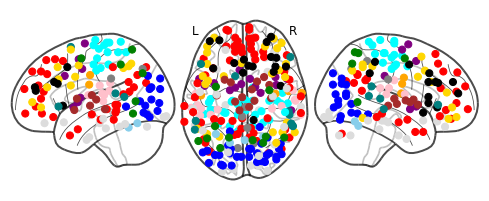

In [3]:
pc = np.zeros((264, 264))
pcol = [x.lower() for x in list(power2011['Color'])]

def colortranslate(x):
    if x.lower() == "yellow":
        return "gold"
    elif x.lower() == "pale blue":
        return "skyblue"
    elif x.lower() == "white":
        return "gainsboro"
    else:
        return x
    
pcol = [colortranslate(x) for x in pcol]
xyz = []
for roi in list(power2011['ROI']):
    entry = power2011.loc[power2011['ROI'] == roi]
    x = int(entry['X'])
    y = int(entry['Y'])
    z = int(entry['Z'])
    xyz.append((x,y,z))
pcoords = np.array(xyz)

img = nip.plot_connectome(pc, pcoords, node_color=pcol, display_mode='lzr')

<ipython-input-4-5f9583950a7d>:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/power2011.png", figsize=(7, 5))


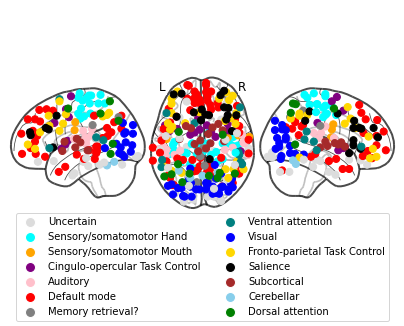

In [4]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
fig, axs = plt.subplots(1,1, figsize=(7,5))
nip.plot_connectome(pc, pcoords, node_color=pcol, display_mode='lzr', axes=axs)

allkols=list(power2011['Color'])
allnets=list(power2011['NetworkName'])

kols=[]
nets=[]
for i in range(len(allkols)):
    if not allkols[i] in kols:
        kols.append(allkols[i])
        nets.append(allnets[i])

handles = [Line2D([0], [0], marker='o', markerfacecolor=x, color="w", markersize=10) for x in [colortranslate(x) for x in kols]]

fig.legend(handles, nets, loc="lower center", ncol=2)
plt.savefig("figures/power2011.png", figsize=(7, 5))
plt.show()

### Visualize the connectome matrix

We can visualize the connectome matrix for the 62 participants. First, we load the data:

In [5]:
subjects = os.listdir("data")

R = np.zeros((264, 264, len(subjects)))
PR = np.zeros((264, 264, len(subjects)))

index = 0
for subj in subjects:
    R[:,:,index]=np.loadtxt("data/%s/R_py.txt" % (subj,))
    PR[:,:,index]=np.loadtxt("data/%s/PR_py.txt" % (subj,))
    index += 1

Then, we visualize it as a matrix

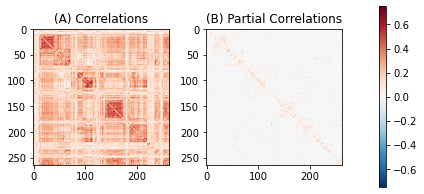

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(6, 3), gridspec_kw={'width_ratios': [20, 20, 1]})
mR = np.mean(R, 2)
mPR = np.mean(PR, 2)

for ii in range(264):
    mR[ii,ii] = 0
    mPR[ii,ii] = 0

im = axs[0].imshow(mR, vmin=-.75, vmax=.75, cmap="RdBu_r")
axs[0].set_title("(A) Correlations")
fig.colorbar(im, cax=axs[2])
axs[1].imshow(mPR, vmin=-0.4, vmax=0.4, cmap="RdBu_r")
axs[1].set_title("(B) Partial Correlations")
#axs[2].set_visible(False)
plt.tight_layout()
plt.savefig("figures/connectomes.png")

### Creating a generic function

Here we assemble all of the steps above into a single function.

In [7]:
### Create a Handy Function

def connectome_visualization_better(variable, name=None, blackbg=True):
    if name is None:
        name = variable
    
    # Load the data
    
    data = pd.read_csv("%s.csv" % (variable,))
    display(data)
    
    # Extract Regions
    
    ROIs = []
    for c in data['connection']:
        roi1, roi2 = c.split("-")

        if int(roi1) not in ROIs:
            ROIs.append(int(roi1))
        if int(roi2) not in ROIs:
            ROIs.append(int(roi2))
    ROIs.sort()

    # Extra ROI data
    
    sub = power2011[power2011['ROI'].isin( ROIs)]
    N = len(sub['ROI'])
    connectome = np.zeros((N, N))
    for c in range(N):
        for r in range(N):
            roi1 = ROIs[c]
            roi2 = ROIs[r]
            conn_name = "%d-%d" % (min(roi1, roi2), max(roi1, roi2))
            entry = data.loc[data['connection'] == conn_name]
            if len(entry) == 1:
                beta=float(entry['Beta'])
                connectome[c,r] = beta
            
    xyz = []
    sub.loc[:,['X', 'Y', 'Z']]
    for roi in ROIs:
        entry = sub.loc[sub['ROI'] == roi]
        x = int(entry['X'])
        y = int(entry['Y'])
        z = int(entry['Z'])
        xyz.append((x,y,z))
    coords = np.array(xyz)
    
    # Figure Legend
    
    colors = []
    sub.loc[:,['Color']]
    for roi in ROIs:
        entry = sub.loc[sub['ROI'] == roi]
        #col = entry['Color']
        col = entry.iloc[0,5]
        colors.append(col.lower())

    # Create Handles for legend
    allkols=list(sub['Color'])
    allnets=list(sub['NetworkName'])


    kols=[]
    nets=[]
    for i in range(len(allkols)):
        if not allkols[i] in kols:
            kols.append(allkols[i])
            nets.append(allnets[i])

    handles = [Line2D([0], [0], marker='o', markerfacecolor=x, color="w", markersize=10) for x in [colortranslate(x) for x in kols]]
    
    # Connectome
    
    fig, axs = plt.subplots(1,1, figsize=(9, 3.5))
    
    emax = max(np.abs(data['Beta']))
    
    nip.plot_connectome(connectome, coords, [colortranslate(x) for x in allkols], 
                    edge_cmap="seismic", axes=axs,
                    display_mode="lzry", colorbar=True, 
                    edge_vmax=emax, edge_vmin=-emax)

    fig.legend(handles, nets, loc="lower center", ncol=3)
    fig.suptitle(r"Neural Correlates of %s" % (name,))
    plt.savefig("figures/%s_pretty.png" % (variable), figsize=(9, 3.5))
    
    # Importance
    
    fig, axs = plt.subplots(1,1, figsize=(9, 3.5))
    nip.plot_connectome_strength(connectome, coords, axes=axs,
                                 cmap="Reds", display_mode="lzry", node_size=100)
    fig.suptitle(r"Importance of ROIs in %s" % (name,))
    plt.savefig("figures/%s_importance.png" % (variable,), figsize=(9, 3.5))
    nip.show()
    
    return connectome, coords, colors

# Zero Back

## Decay rate $d$

We use the new function to plot a different variable, the decay rate $d$

,index,network,network_names,connection,censor,Beta
0,31450,1-5,Sensory/somatomotor Hand-Default mode,34-120,True,-0.001006
1,38870,4-7,Auditory-Visual,62-148,True,-0.082317


<ipython-input-7-449fecf8e79e>:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/%s_pretty.png" % (variable), figsize=(9, 3.5))
<ipython-input-7-449fecf8e79e>:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/%s_importance.png" % (variable,), figsize=(9, 3.5))


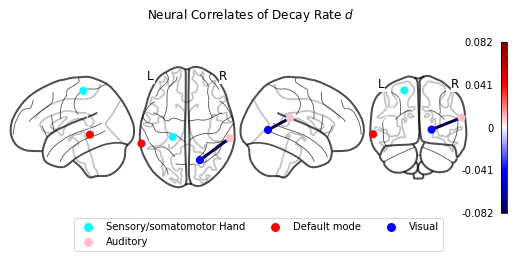

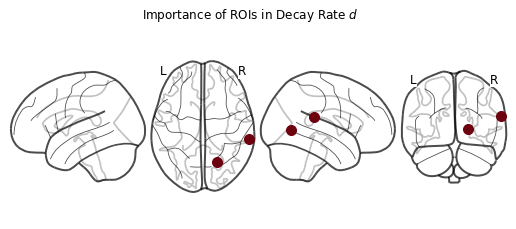

In [8]:
conn, xyz, cols = connectome_visualization_better("bll_0b", "Decay Rate $d$")

## Goal Activation $W_g$

Some prettier visualizations. First, we need to get the network names and colors.

,index,network,network_names,connection,censor,Beta
0,36994,-1-1,Uncertain-Sensory/somatomotor Hand,34-141,True,-0.052415
1,47797,-1-1,Uncertain-Sensory/somatomotor Hand,13-182,True,-0.126170
2,59847,-1-10,Uncertain-Subcortical,183-227,True,0.339028
3,62389,-1-11,Uncertain-Ventral attention,85-237,True,-0.079886
4,63626,-1-11,Uncertain-Ventral attention,2-242,True,0.355454
...,...,...,...,...,...,...
84,50867,8-8,Fronto-parietal Task Control-Fronto-parietal T...,179-193,True,0.340692
85,52712,8-8,Fronto-parietal Task Control-Fronto-parietal T...,176-200,True,0.001277
86,52731,8-8,Fronto-parietal Task Control-Fronto-parietal T...,195-200,True,0.188850
87,54042,8-9,Fronto-parietal Task Control-Salience,186-205,True,0.133337


<ipython-input-7-449fecf8e79e>:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/%s_pretty.png" % (variable), figsize=(9, 3.5))
<ipython-input-7-449fecf8e79e>:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/%s_importance.png" % (variable,), figsize=(9, 3.5))


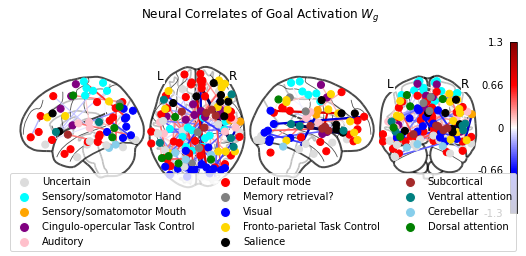

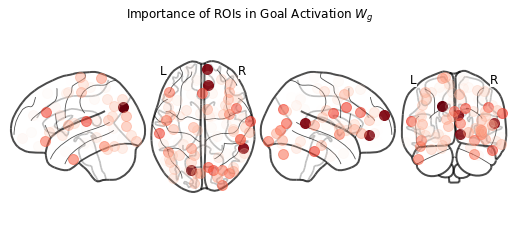

In [9]:
conn, xyz, cols = connectome_visualization_better("ga_0b", "Goal Activation $W_g$")

## Imaginal Activation $W_i$

Here is the data for $W_i$

,index,network,network_names,connection,censor,Beta
0,7150,1-1,Sensory/somatomotor Hand-Sensory/somatomotor Hand,22-28,True,0.007862
1,26686,1-5,Sensory/somatomotor Hand-Default mode,22-102,True,-0.217305
2,64729,3-13,Cingulo-opercular Task Control-Cerebellar,49-246,True,0.109730
3,52142,6-8,Memory retrieval?-Fronto-parietal Task Control,134-198,True,-0.294649
4,57995,8-9,Fronto-parietal Task Control-Salience,179-220,True,-0.111168


<ipython-input-7-449fecf8e79e>:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/%s_pretty.png" % (variable), figsize=(9, 3.5))
<ipython-input-7-449fecf8e79e>:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/%s_importance.png" % (variable,), figsize=(9, 3.5))


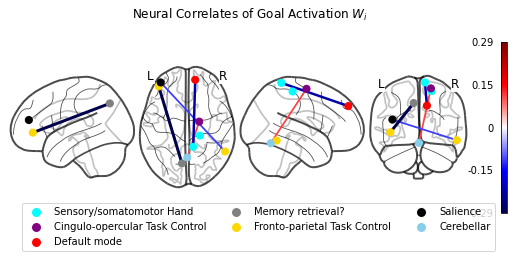

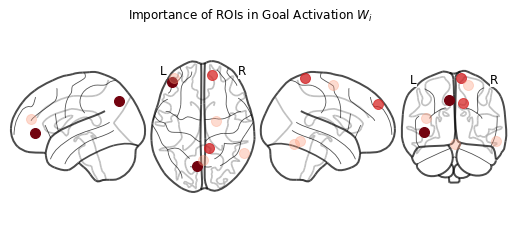

In [10]:
conn, xyz, cols = connectome_visualization_better("ia_0b", "Goal Activation $W_i$")

## Mismatch parameter $M$

Here is the `css` parameter

,index,network,network_names,connection,censor,Beta
0,1850,-1--1,Uncertain-Uncertain,2-8,True,0.042605
1,37228,-1--1,Uncertain-Uncertain,4-142,True,-0.108303
2,65455,-1--1,Uncertain-Uncertain,247-248,True,-0.005797
3,6076,-1-1,Uncertain-Sensory/somatomotor Hand,4-24,True,-0.085245
4,67064,-1-1,Uncertain-Sensory/somatomotor Hand,8-255,True,0.265120
...,...,...,...,...,...,...
61,46345,7-8,Visual-Fronto-parietal Task Control,145-176,True,0.097830
62,51640,7-8,Visual-Fronto-parietal Task Control,160-196,True,-0.012504
63,55592,7-9,Visual-Salience,152-211,True,0.226301
64,62217,8-11,Fronto-parietal Task Control-Ventral attention,177-236,True,-0.080967


<ipython-input-7-449fecf8e79e>:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/%s_pretty.png" % (variable), figsize=(9, 3.5))
<ipython-input-7-449fecf8e79e>:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/%s_importance.png" % (variable,), figsize=(9, 3.5))


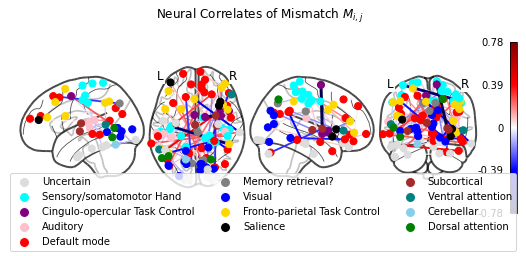

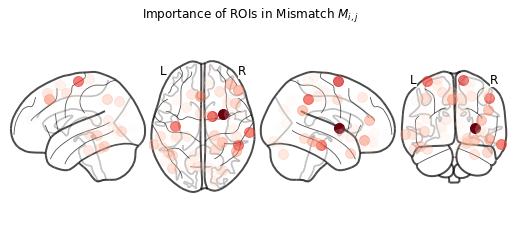

In [11]:
conn, xyz, cols = connectome_visualization_better("css_0b", "Mismatch $M_{i,j}$")

# 2-back Task

This is the "real" _N_-back.

## Decay $d$

The decay rate

,index,network,network_names,connection,censor,Beta
0,65854,-1-5,Uncertain-Default mode,118-250,True,-0.172962
1,42774,-1-7,Uncertain-Visual,6-163,True,0.062212
2,55443,-1-9,Uncertain-Salience,3-211,True,-0.262971
3,62854,1-11,Sensory/somatomotor Hand-Ventral attention,22-239,True,-0.005356
4,67102,1-2,Sensory/somatomotor Hand-Sensory/somatomotor M...,46-255,True,-0.048815
5,45446,1-7,Sensory/somatomotor Hand-Visual,38-173,True,-0.022720
6,46753,1-8,Sensory/somatomotor Hand-Fronto-parietal Task ...,25-178,True,-0.003158
7,49669,1-8,Sensory/somatomotor Hand-Fronto-parietal Task ...,37-189,True,0.016676
8,29355,3-5,Cingulo-opercular Task Control-Default mode,51-112,True,-0.147302
9,36496,4-5,Auditory-Default mode,64-139,True,-0.051601


<ipython-input-7-449fecf8e79e>:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/%s_pretty.png" % (variable), figsize=(9, 3.5))
<ipython-input-7-449fecf8e79e>:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/%s_importance.png" % (variable,), figsize=(9, 3.5))


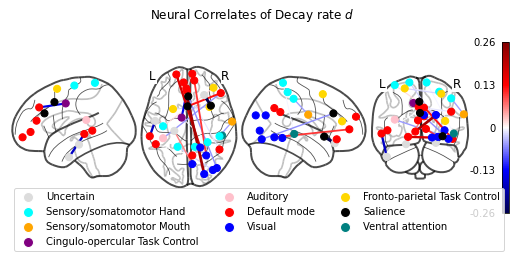

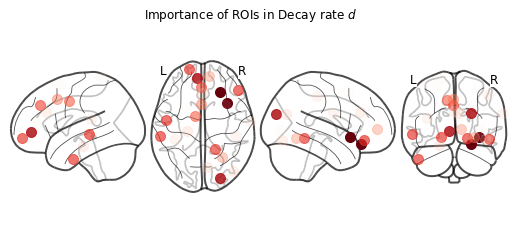

In [12]:
conn, xyz, cols = connectome_visualization_better("bll_2b", "Decay rate $d$")

## Imaginal activation $W_i$

,index,network,network_names,connection,censor,Beta
0,67020,-1-10,Uncertain-Subcortical,228-254,True,-0.167677
1,30116,1-5,Sensory/somatomotor Hand-Default mode,20-115,True,-0.220765
2,34378,3-5,Cingulo-opercular Task Control-Default mode,58-131,True,0.161762
3,64788,5-13,Default mode-Cerebellar,108-246,True,-0.507469
4,41546,5-7,Default mode-Visual,98-158,True,0.693884
5,51032,5-8,Default mode-Fronto-parietal Task Control,80-194,True,0.078166


<ipython-input-7-449fecf8e79e>:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/%s_pretty.png" % (variable), figsize=(9, 3.5))
<ipython-input-7-449fecf8e79e>:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/%s_importance.png" % (variable,), figsize=(9, 3.5))


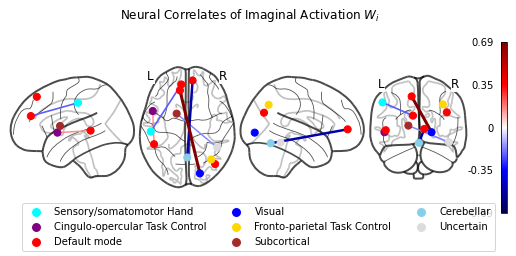

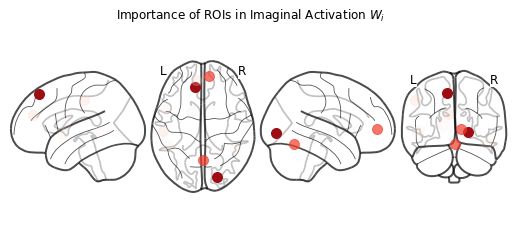

In [13]:
conn, xyz, cols = connectome_visualization_better("ia_2b", "Imaginal Activation $W_i$")

## Latency Factor $F$

,index,network,network_names,connection,censor,Beta
0,14527,-1-3,Uncertain-Cingulo-opercular Task Control,7-56,True,0.246135
1,24838,1-5,Sensory/somatomotor Hand-Default mode,22-95,True,0.012757
2,46515,3-8,Cingulo-opercular Task Control-Fronto-parietal...,51-177,True,0.485709
3,51007,3-8,Cingulo-opercular Task Control-Fronto-parietal...,55-194,True,-0.217990
4,53117,3-8,Cingulo-opercular Task Control-Fronto-parietal...,53-202,True,-0.488986
5,31241,5-5,Default mode-Default mode,89-119,True,0.898376
6,39941,5-7,Default mode-Visual,77-152,True,-0.153264
7,43682,5-7,Default mode-Visual,122-166,True,0.906182
8,68537,7-12,Visual-Dorsal attention,161-260,True,0.089319
9,43988,7-7,Visual-Visual,164-167,True,0.069286


<ipython-input-7-449fecf8e79e>:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/%s_pretty.png" % (variable), figsize=(9, 3.5))
<ipython-input-7-449fecf8e79e>:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/%s_importance.png" % (variable,), figsize=(9, 3.5))


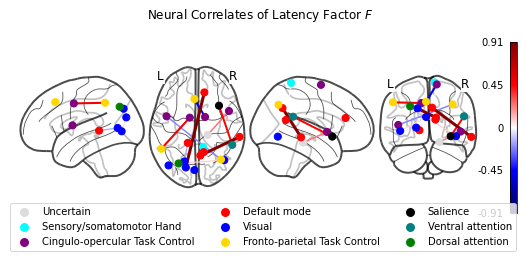

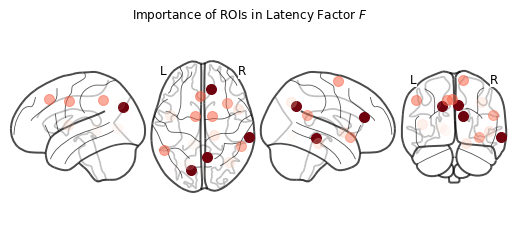

In [14]:
conn, xyz, cols = connectome_visualization_better("lf_2b", "Latency Factor $F$")

Fluid Intelligence $G_f$

In [16]:
conn, xyz, cols = connectome_visualization_better("Gf_allParts", "Fluid Intelligence $G_F$")

FileNotFoundError: [Errno 2] No such file or directory: 'Gf_allParts.csv'